<div style="border: 2px solid #575757; padding: 10px; border-radius: 5px; background-color: #e1e1e1; color: black; text-align: center;">
  <h1 style="margin: 0;">Tirage au sort des participant·es</h1>
</div>

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Importation des librairies</h2>
</div>

**Ce bloc importe les bibliothèques nécessaires au fonctionnement de l'outil:**
1. Manipulation et gestion des données
    - `pandas` (pd) : manipulation de données tabulaires, filtres, agrégations, lectures/écritures de fichiers, etc
    - `numpy` (np) : calcul numérique, génération de valeurs aléatoires
    - `collections.Counter` : comptage rapide de la fréquence d’éléments
2. Mathématiques et optimisation
    - `math` : fonctions mathématiques
    - `random` : génération de valeurs et tirages aléatoires
    - `pulp` : modélisation et résolution de problèmes d’optimisation linéaire ou entière
    - `sklearn.preprocessing.LabelEncoder` : encodage numérique de catégories textuelles (pour traitement algorithmique)
3. Visualisation
    - `matplotlib.pyplot` : création de graphiques
    - `matplotlib.gridspec` : gestion des sous-graphes
    - `matplotlib.colors` : manipulation des couleurs
    - `seaborn` : visualisation esthétique
4. Interaction et interface utilisateur (Jupyter)
    - `ipywidgets` : création de widgets interactifs (sliders, menus, boutons)
    - `ipywidgets.X` :
        - `Layout` : style et disposition des widgets
        - `interact` : interface interactive pour une fonction
        - `IntSlider` : curseur pour sélectionner un entier
    - `IPython.display.X`
        - `display` : affichage d’objets (DataFrames, widgets, HTML)
        - `clear_output` : effacement dynamique affichage
    - `tqdm.notebook` : barre de progression interactive

In [1]:
# Librairies nécessaires
import pandas as pd
import numpy as np
from collections import Counter
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output
from tqdm.notebook import tqdm

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Lecture du fichier et filtrage par disponibilités</h2>
</div>

**Ce bloc importe les réponses à l'appel à participation depuis le CSV stocké dans le dossier `/data` :**

In [ ]:
# Lecture du fichier avec en-tête correct (3e ligne)
df = pd.read_csv("../data/appel_participation.csv", header=2)

**Ce bloc demande à l'utilisateur·ice de sélectionner un CSV à importer :**

In [25]:
import io
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Widgets
upload = widgets.FileUpload(
    accept='.csv',
    multiple=False,
    description='Choisir un CSV'
)
header_row = widgets.IntText(
    value=2,  # 3e ligne = header=2
    description='Lignes entête',
    layout=widgets.Layout(width='140px')  # largeur plus grande pour afficher tout le texte
)
btn_load = widgets.Button(
    description='Charger dans un DataFrame (df)',
    button_style='primary',
    tooltip="Lire le CSV sélectionné et créer la variable globale 'df'",
    layout=widgets.Layout(width='210px')  # largeur adaptée au texte
)
out = widgets.Output()

def _extract_first_file(upload_value):
    if not upload_value:
        return None, None
    if isinstance(upload_value, dict):  # ipywidgets v7
        (name, info), = upload_value.items()
        return name, info['content']
    if isinstance(upload_value, (tuple, list)):  # ipywidgets v8
        info = upload_value[0]
        return info.get('name', 'fichier.csv'), info.get('content', None)
    return None, None

@out.capture(clear_output=True, wait=True)
def on_click_load(_):
    name, content = _extract_first_file(upload.value)
    if content is None:
        print("⚠️ Aucun fichier sélectionné. Sélectionne un CSV puis clique sur 'Charger dans un DataFrame (df)'.")
        return
    try:
        df_local = pd.read_csv(io.BytesIO(content), header=header_row.value, sep=None, engine='python')
        global df
        df = df_local
        print(f"✅ Fichier importé : {name}")
        print(f"📊 Dimensions : {df.shape[0]} lignes × {df.shape[1]} colonnes (header={header_row.value})")
    except Exception as e:
        print(f"❌ Erreur lors de la lecture : {e}")

btn_load.on_click(on_click_load)

display(widgets.VBox([
    widgets.Label("📂 Importer un fichier de candidat·es (CSV)"),
    upload,
    header_row,
    btn_load,
    out
]))

**Il est possible de réaliser un premier filtrage basé sur le nombre de disponibilités aux WEs de la Convention:**
- 1 si une seule disponibilité est considérée suffisante
- 4 si l'on souhaite restreindre la sélection aux personnes complètement disponibles

**Un tableau synthétique permettant de mesurer l'ampleur du filtrage est affiché et modifié dynamiquement selon le filtrage retenu.**

In [26]:
# Nettoyage des noms de colonnes
df.columns = (
    df.columns
    .str.strip()
    .str.replace('\n', ' ', regex=False)
    .str.replace('\r', '', regex=False)
    .str.replace(' +', ' ', regex=True)
)

# Colonnes de disponibilité détectées automatiquement
dispo_cols = [col for col in df.columns if any(mois in col.lower() for mois in ["octobre", "novembre", "décembre", "janvier"])]

print("Colonnes de disponibilité détectées :")
for col in dispo_cols:
    print("-", col)

# Ajout d'une colonne avec le nombre total de WE disponibles
df["Nb_dispos"] = df[dispo_cols].apply(lambda row: sum("oui" in str(val).lower() for val in row), axis=1)

# Slider interactif pour définir le seuil
seuil_widget = widgets.IntSlider(
    value=4,
    min=1,
    max=len(dispo_cols),
    step=1,
    description='WE dispos:',
    continuous_update=False,
    layout=Layout(width='500px')
)

# Zone d’affichage dynamique
output = widgets.Output()

# Fonction de filtrage + affichage dynamique
def update_table(_change):
    seuil = seuil_widget.value
    df_filtre = df[df["Nb_dispos"] >= seuil].reset_index(drop=True)

    with output:
        clear_output(wait=True)
        print(f"🎯 {len(df_filtre)} participant·es ont au moins {seuil} week-ends de disponibilité :")
        display(df_filtre[["Séquentiel", "SID", "Nb_dispos"] + dispo_cols])

# Lier l’interaction au slider
seuil_widget.observe(update_table, names='value')

# Afficher les widgets
display(seuil_widget, output)

# Initialiser l'affichage
update_table(None)

Colonnes de disponibilité détectées :
- 4 et 5 octobre 2025 - Université Paris-Est Créteil
- 15 et 16 novembre 2025 - Institut Arts et Métiers de Chambéry
- 6 et 7 décembre 2025 - Université de technologie de Troyes
- 17 et 18 janvier 2026 - Nantes Université


IntSlider(value=4, continuous_update=False, description='WE dispos:', layout=Layout(width='500px'), max=4, min…

Output()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Extraction des données pour tirage au sort</h2>
</div>

**À partir du filtrage, ce bloc extrait et structure les informations nécessaires au tirage au sort:**

| Critère             | Colonne / transformation                  |
| ------------------- | ----------------------------------------- |
| **Genre**           | `Genre` (3 valeurs : Homme, Femme, Autre) |
| **Thématiques CNU** | `Thématiques` (liste de thématiques)      |
| **Profil pro**      | `Secteur` (Public, Privé, Autre)          |
| **Géographie**      | 3 colonnes `Département X` (`origine`, `thèse`, `emploi`)  |
| **Expérience**      | `Année soutenance`                  |



In [3]:
# On part du DataFrame filtré à l’étape précédente
# On peut sauvegarder df_filtre depuis le bloc[Convention scientifique IESF] Proposition d'intervention 1 dans une variable globale
df_selection = df[df["Nb_dispos"] >= seuil_widget.value].copy()

# Genre – regroupement en 3 catégories simples
genre_cols = ["Une femme", "Un homme", "Autre", "Je préfère ne pas le dire"]
def get_genre(row):
    if row["Une femme"] == "X":
        return "Femme"
    elif row["Un homme"] == "X":
        return "Homme"
    elif row["Autre"] == "X":
        return "Autre"
    else:
        return "Non spécifié"
df_selection["Genre"] = df_selection.apply(get_genre, axis=1)

# Thématiques CNU – booléen par thématique
# On extrait dynamiquement les colonnes entre les deux libellés connus
theme_start = "Droit privé et sciences criminelles"
theme_end = "Sciences biologiques pharmaceutiques"
theme_mask = df.columns.to_list()
start_idx = theme_mask.index(theme_start)
end_idx = theme_mask.index(theme_end)
theme_cols = theme_mask[start_idx:end_idx + 1]

# Création d'une colonne 'Thématiques' avec la liste des thèmes sélectionnés
df_selection["Thématiques"] = df_selection[theme_cols].apply(
    lambda row: [col for col in theme_cols if str(row[col]).strip().upper() == "X"],
    axis=1
)

# Profil professionnel – en simplifiant la colonne "Dans quel secteur travaillez-vous ?"
df_selection["Secteur"] = df_selection["Dans quel secteur travaillez-vous ?"].fillna("Non spécifié")

# Diversité géographique – regrouper 3 colonnes
geo_cols = {
    "Département origine": "Quel est le département dans lequel vous avez grandi ?",
    "Département thèse": "Quel est le département de votre école doctorale ?",
    "Département emploi": "Quel est votre département d'emploi ?"
}
for col_nom, source in geo_cols.items():
    df_selection[col_nom] = df_selection[source].fillna("Non précisé").astype(str).str.strip()

# Expérience – année de soutenance (ou prévue)
df_selection["Année soutenance"] = df_selection[
    "En quelle année avez-vous soutenu votre thèse ou prévoyez-vous de la soutenir si vous êtes encore doctorant(e) ?"
].replace(" ", np.nan).fillna("Non précisé")

# Aperçu rapide des variables extraites
df_selection_small = df_selection[
    ["Séquentiel", "SID", "Genre", "Thématiques", "Secteur"] +
    list(geo_cols.keys()) + ["Année soutenance"]
]

print(f"🎯 Données des {len(df_selection_small)} participant·es sélectionné·es pour le tirage au sort:")
display(df_selection_small.head(10))

🎯 Données des 73 participant·es sélectionné·es pour le tirage au sort:


,Séquentiel,SID,Genre,Thématiques,Secteur,Département origine,Département thèse,Département emploi,Année soutenance
0,5,28412735,Femme,"[Milieux denses et matériaux, Chimie des matér...",Public,Seine-et-Marne,Somme,Hauts-de-Seine,2022
3,8,28515736,Femme,"[Science politique, Sciences de gestion, Aména...",Public,Alpes-Maritimes,Alpes-Maritimes,Aube,2019
6,11,28522685,Femme,"[Génie informatique, automatique et traitement...",Public,Haute-Garonne,Haute-Garonne,Haute-Garonne,2024
7,12,28523202,Homme,"[Mécanique, génie mécanique, génie civil, Éner...",Public,Rhône,Paris,Gironde,2014
8,13,28523698,Homme,"[Météorologie, océanographie physique et physi...",Public,Landes,Bouches-du-Rhône,Pas-de-Calais,2014
9,14,28528996,Homme,"[Mécanique, génie mécanique, génie civil, Biol...",Public,Hauts-de-Seine,Paris,Paris,2011
12,17,28531926,Femme,"[Architecture, arts appliqués, arts plastiques...",Public,Isère,Bas-Rhin,Loire,2016
16,21,28540270,Femme,"[Géographie physique, humaine, économique et r...",Privé,À l'étranger,Hérault,Paris,2023
17,22,28544590,Femme,"[Sociologie, démographie]",Privé,Marne,Paris,Marne,2016
18,23,28547574,Femme,"[Milieux denses et matériaux, Mécanique, génie...",Privé,Nord,Nord,Yvelines,2022


<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Visualisation de la diversité de la pré-sélection</h2>
</div>

**Ce bloc trace un ensemble de figures permettant de visualiser la répartition des candidat·es pré-sélectionné·es pour le tirage au sort :**
- Genre
- Nombre de thématiques cochées par candidat·es
- Secteur d'activité
- Année de soutenance
- Thémathique CNU
- Département :
    - d'origine
    - de thèse
    - d'emploi 

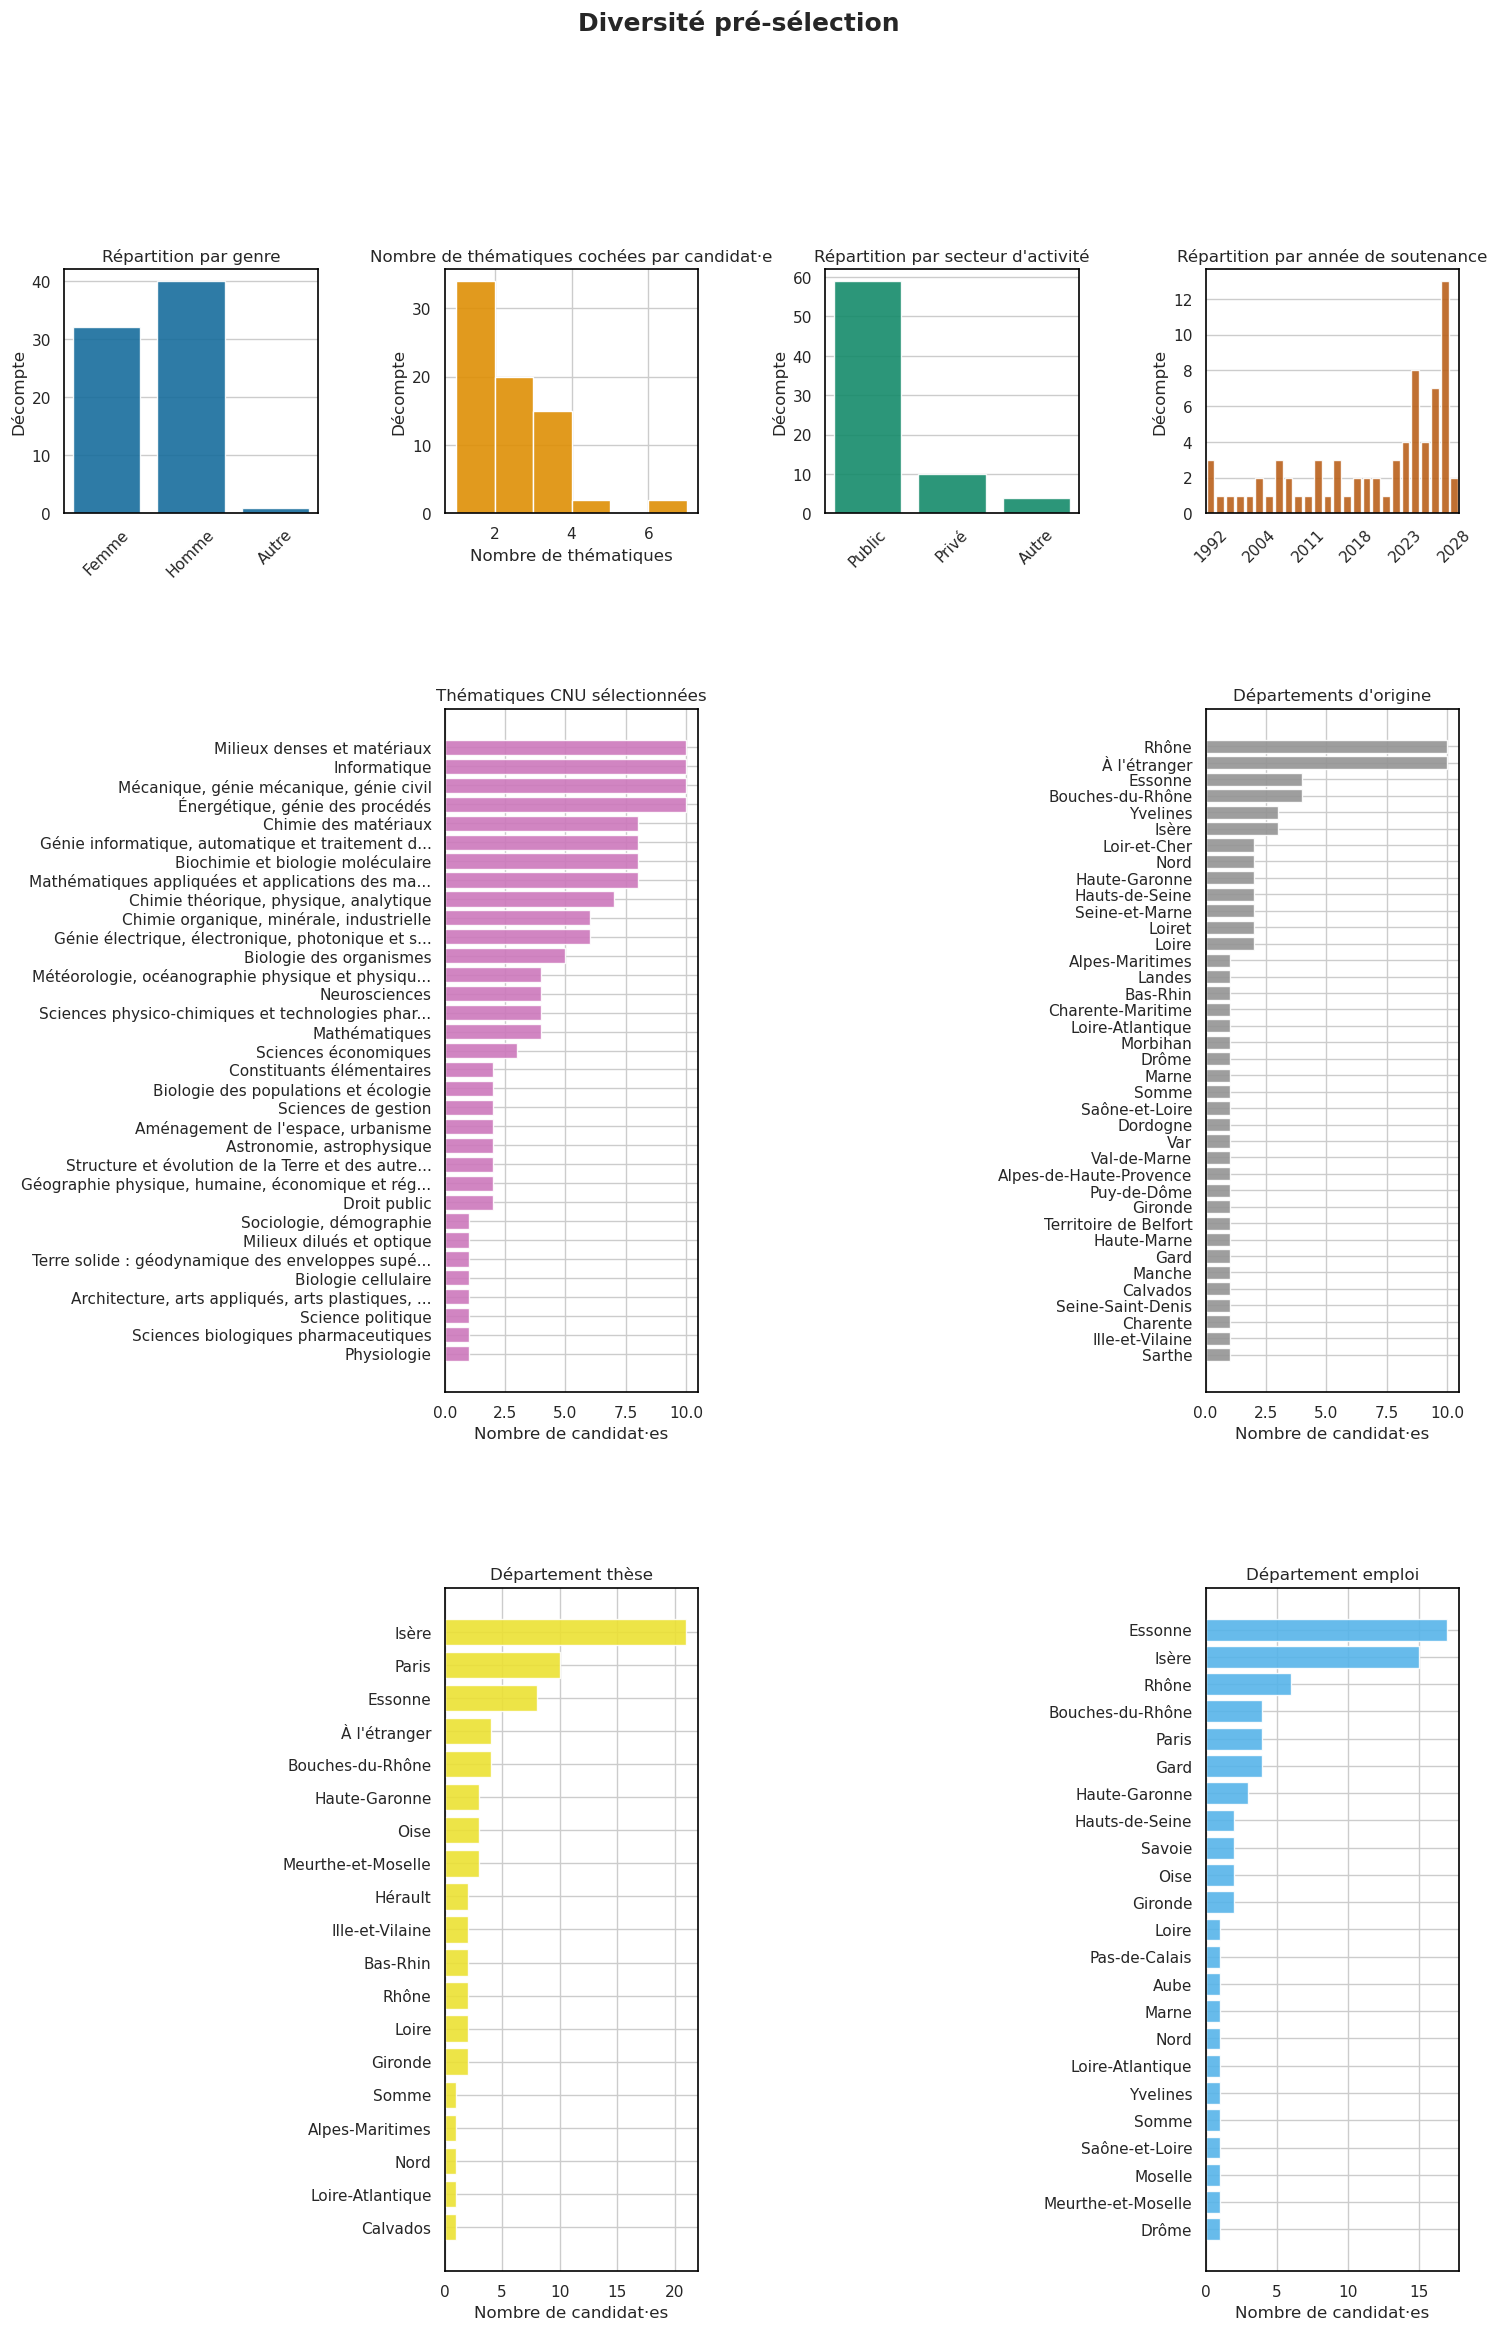

In [4]:
# Fonction pour couper les labels trop longs
def truncate_label(label, max_char=50):
    return label if len(label) <= max_char else label[:max_char - 3] + "..."

# Style et couleurs
palette = sns.color_palette("colorblind")
sns.set_theme(style="whitegrid")
alpha_bg = 0.9  # plus visible maintenant que le panel n'est plus présent
colors = palette[:10]
max_char = 50

# Préparation de la figure
fig = plt.figure(figsize=(18, 26), facecolor='white')
fig.suptitle("Diversité pré-sélection", fontsize=18, weight='bold')

# Grille personnalisée
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 1], hspace=0.8, wspace=0.5)

# Petits graphiques (ligne 0)
ax1 = fig.add_subplot(gs[0, 0])  # Genre
ax2 = fig.add_subplot(gs[0, 1])  # Nb thématiques
ax3 = fig.add_subplot(gs[0, 2])  # Secteur
ax4 = fig.add_subplot(gs[0, 3])  # Année soutenance

# Grands graphiques (colonnes 1 et 3, lignes 1 à 4)
ax5 = fig.add_subplot(gs[1:3, 1])  # Thématiques
ax6 = fig.add_subplot(gs[1:3, 3])  # Département origine
ax7 = fig.add_subplot(gs[3:5, 1])  # Département thèse
ax8 = fig.add_subplot(gs[3:5, 3])  # Département emploi

# 1. Genre
sns.countplot(data=df_selection, x="Genre", ax=ax1, color=colors[0], alpha=alpha_bg)
ax1.set_title("Répartition par genre")
ax1.tick_params(axis='x', rotation=45)
ax1.set(xlabel=None, ylabel="Décompte")

# 2. Nombre de thématiques cochées
df_selection["Nb_thématiques"] = df_selection["Thématiques"].apply(len)
bins = range(1, df_selection["Nb_thématiques"].max() + 2)
sns.histplot(df_selection["Nb_thématiques"], bins=bins, ax=ax2, color=colors[1], alpha=alpha_bg)
ax2.set_title("Nombre de thématiques cochées par candidat·e")
ax2.set(xlabel="Nombre de thématiques", ylabel="Décompte")

# 3. Secteur
sns.countplot(data=df_selection, x="Secteur", ax=ax3, color=colors[2], alpha=alpha_bg)
ax3.set_title("Répartition par secteur d'activité")
ax3.tick_params(axis='x', rotation=45)
ax3.set(xlabel=None, ylabel="Décompte")

# 4. Année de soutenance
try:
    df_years = df_selection["Année soutenance"].dropna().astype(int).astype(str)
    all_years = sorted(df_years.unique())
    sns.countplot(x=df_years, order=all_years, ax=ax4, color=colors[3], alpha=alpha_bg)
    ax4.set_title("Répartition par année de soutenance")
    ax4.tick_params(axis='x', rotation=45)
    interval = 5
    tick_positions = np.arange(len(all_years))
    tick_labels = [year if i % interval == 0 else '' for i, year in enumerate(all_years)]
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    ax4.set(xlabel=None, ylabel="Décompte")
except Exception as e:
    ax4.axis("off")
    ax4.text(0.5, 0.5, f"Année de soutenance non exploitable\n({str(e)})", ha='center', va='center')

# 5. Thématiques
all_thematiques = list(set(t for sub in df_selection["Thématiques"] for t in sub))
df_counts = Counter([t for sub in df_selection["Thématiques"] for t in sub])
all_thematiques_sorted = sorted(all_thematiques, key=lambda x: df_counts.get(x, 0), reverse=True)
trunc_labels = [truncate_label(l, max_char) for l in all_thematiques_sorted]
df_vals = [df_counts.get(l, 0) for l in all_thematiques_sorted]
ax5.barh(trunc_labels, df_vals, color=colors[4], alpha=alpha_bg)
ax5.set_title("Thématiques CNU sélectionnées")
ax5.invert_yaxis()
ax5.set_xlabel("Nombre de candidat·es")
ax5.set(ylabel=None)

# 6. Département origine
all_depts = df_selection["Département origine"].dropna().unique()
df_vals_dept = df_selection["Département origine"].value_counts()
all_depts_sorted = df_vals_dept.index.tolist()
ax6.barh(all_depts_sorted, df_vals_dept.values, color=colors[7], alpha=alpha_bg)
ax6.set_title("Départements d'origine")
ax6.invert_yaxis()
ax6.set_xlabel("Nombre de candidat·es")
ax6.set(ylabel=None)

# 7. Département thèse
all_th = df_selection["Département thèse"].dropna().unique()
df_vals_th = df_selection["Département thèse"].value_counts()
all_th_sorted = df_vals_th.index.tolist()
ax7.barh(all_th_sorted, df_vals_th.values, color=colors[8], alpha=alpha_bg)
ax7.set_title("Département thèse")
ax7.invert_yaxis()
ax7.set_xlabel("Nombre de candidat·es")
ax7.set(ylabel=None)

# 8. Département emploi
all_emp = df_selection["Département emploi"].dropna().unique()
df_vals_emp = df_selection["Département emploi"].value_counts()
all_emp_sorted = df_vals_emp.index.tolist()
ax8.barh(all_emp_sorted, df_vals_emp.values, color=colors[9], alpha=alpha_bg)
ax8.set_title("Département emploi")
ax8.invert_yaxis()
ax8.set_xlabel("Nombre de candidat·es")
ax8.set(ylabel=None)

# Bordures noires
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.show()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Tirage au sort</h2>
</div>

**Ce bloc permet de lancer un grand nombre de tirages aléatoires de panels et de garder celui qui maximise un score de diversité pondéré sélectionné.**

**Structure générale :**
- Widgets : menus *sliders* et *dropdown* pour contrôler les variables `N_TIRS`, `TAILLE_PANEL`, `geo_mode` (géographie simplifiée ou complète) et les pondérations des différents critères ; un bouton `run_button` (lancer la sélection) ; un output pour capturer l’affichage.
- Encodages (`LabelEncoder`) construits à partir de `df_selection` (pré-sélection à partir du nombre de week-ends disponibles) pour convertir les catégories en codes numériques (secteur, départements, année).
- Fonction `diversite_score` : calcule un score de diversité pour un *DataFrame* (tableau de données) de candidat·es selon les cinq critères mentionnés précédemment (genre, thématiques, secteur, géographie, expérience) puis combine ces scores pondérés.
- Fonction `lancer_tirage` (attachée au bouton) :
    - Lit les paramètres depuis les widgets
    - Réalise `N_TIRS` tirages aléatoires de taille `TAILLE_PANEL`
    - Calcule `diversite_score` pour chaque tirage
    - Conserve le tirage ayant le meilleur score dans la **variable globale** `best_panel`
    - Affiche un message et (optionnellement, commenter/décommenter le code correspondant) des aperçus


In [5]:
## Définition des Widgets pour l'interactivité
n_tirs_widget = widgets.IntSlider(value=5000, min=100, max=10000, step=100, description="🎲 Tirages")
panel_size_widget = widgets.IntSlider(value=50, min=10, max=100, step=1, description="👥 Panel")

geo_mode_widget = widgets.Dropdown(
    options=["simplifiée", "complète"],
    value="simplifiée",
    description="🌍 Géographie"
)

weights_widgets = {
    "genre": widgets.IntSlider(value=5, min=0, max=10, description="Genre"),
    "thématiques": widgets.IntSlider(value=4, min=0, max=10, description="Thématiques"),
    "secteur": widgets.IntSlider(value=3, min=0, max=10, description="Secteur"),
    "géographie": widgets.IntSlider(value=2, min=0, max=10, description="Géographie"),
    "expérience": widgets.IntSlider(value=1, min=0, max=10, description="Expérience")
}

run_button = widgets.Button(description="🚀 Lancer le tirage", button_style='success')

output = widgets.Output()

## Encodage
# On fait un fit de plusieurs LabelEncoder sur df_selection (les classes uniques sont mémorisées).
# fillna("Inconnu") garantit qu’il n’y ait pas de NaN au fit.
# Remarques :
# Si une colonne indiquée n’existe pas, .fit(...) lèvera une erreur — vérifie la présence des colonnes.
# Ces encodeurs permettent ensuite de transformer une sous-sélection (tirage) en codes entiers et compter facilement les catégories (avec set(...)).

le_secteur = LabelEncoder().fit(df_selection["Secteur"].fillna("Inconnu"))
le_origine = LabelEncoder().fit(df_selection["Département origine"].fillna("Inconnu"))
le_these = LabelEncoder().fit(df_selection["Année soutenance"].fillna(""))

# Encodages pour mode "complet"
le_geo_origine = LabelEncoder().fit(df_selection["Département origine"].fillna("Inconnu"))
le_geo_these = LabelEncoder().fit(df_selection["Département thèse"].fillna("Inconnu"))
le_geo_emploi = LabelEncoder().fit(df_selection["Département emploi"].fillna("Inconnu"))

## Fonction de score

def diversite_score(candidats: pd.DataFrame, weights: dict, geo_mode: str) -> float:
# Entrées : candidats (DataFrame du tirage), weights (dict des pondérations), geo_mode (string).
# Retour : un score numérique (plus élevé → panel jugé « plus diversifié » selon la combinaison choisie).

    # 1. Genre
    # Récupérer la proportion par modalité
    genre_counts = candidats["Genre"].value_counts(normalize=True)
    # Proportion catégorie "Une femme", 0 si absente
    p_femme = genre_counts.get("Une femme", 0)
    # Score de 1 si proportion femme = 0.5 (parité), 0 si un seul genre
    genre_score = 1 - abs(p_femme - 0.5) * 2

    # 2. Thématiques
    # Aplatissement listes de thématiques pour chaque candidat·e 
    all_thematiques = [t for sublist in candidats["Thématiques"] for t in sublist]
    # Nb thématiques distinctes dans le tirage
    nb_thematiques_uniques = len(set(all_thematiques))
    # Ratio mesurant la diversité
    thematiques_score = nb_thematiques_uniques / len(all_thematiques)

    # 3. Secteur
    # Transforme le secteur en code
    secteur_codes = le_secteur.transform(candidats["Secteur"].fillna("Inconnu"))
    # Compte combien de codes différents sont présents
    # Normalise par le nombre total de classes connues (public/privé/other)
    secteur_score = len(set(secteur_codes)) / len(le_secteur.classes_)

    # 4. Géographie
    # Simplifiée : Département origine normalisé par le nb de classes
    if geo_mode == "simplifiée":
        geo_codes = le_origine.transform(candidats["Département origine"].fillna("Inconnu"))
        geo_score = len(set(geo_codes)) / len(le_origine.classes_)
    # 3 scores calculés (origine / thèse / emploi), chacun normalisé, puis moyenne simple
    else:  # complète
        geo_origine_codes = le_geo_origine.transform(candidats["Département origine"].fillna("Inconnu"))
        geo_these_codes = le_geo_these.transform(candidats["Département thèse"].fillna("Inconnu"))
        geo_emploi_codes = le_geo_emploi.transform(candidats["Département emploi"].fillna("Inconnu"))
        geo_score = (
            len(set(geo_origine_codes)) / len(le_geo_origine.classes_) +
            len(set(geo_these_codes)) / len(le_geo_these.classes_) +
            len(set(geo_emploi_codes)) / len(le_geo_emploi.classes_)
        ) / 3

    # 5. Expérience
    # Transforme l’année de soutenance en code
    annee_codes = le_these.transform(candidats["Année soutenance"].fillna(""))
    # Compte combien de codes différents sont présents
    # Normalise par le nombre total de classes connues (total d'années différentes)
    exp_score = len(set(annee_codes)) / len(le_these.classes_)

    # Score total pondéré
    # Des poids plus élevés favorisent le critère correspondant
    total = (
        genre_score * weights["genre"] +
        thematiques_score * weights["thématiques"] +
        secteur_score * weights["secteur"] +
        geo_score * weights["géographie"] +
        exp_score * weights["expérience"]
    )
    return total

## Fonction de tirage
def lancer_tirage(b):
    global best_panel  # <-- permet d'utiliser best_panel partout
    with output:
        clear_output()
        print("🔁 Démarrage du tirage optimisé...")

        # Récupération de N_TIRS, TAILLE_PANEL, geo_mode.
        N_TIRS = n_tirs_widget.value
        TAILLE_PANEL = panel_size_widget.value
        geo_mode = geo_mode_widget.value
        # Dictionnaire d’entiers créé à partir des valeurs actuelles des sliders
        weights = {k: w.value for k, w in weights_widgets.items()}

        # Intitialisations
        # best_score initialisé bas pour être battu
        best_score = -1
        # Stockage du meilleur tirage
        best_panel = None
        # barre de progression pour visualiser l’avancement
        pbar = tqdm(total=N_TIRS)

        # À chaque itération, on prélève au hasard TAILLE_PANEL lignes de df_selection
        # Variation de l’aléa par random_state=random.randint(...)
        # Reproduction possible si on fixe la seed du module random
        for _ in range(N_TIRS):
            tirage = df_selection.sample(n=TAILLE_PANEL, random_state=random.randint(0, 999999))
            # On calcule diversite_score sur tirage
            score = diversite_score(tirage, weights, geo_mode)
            # Si score meilleur que précédemment, on remplace best_panel et best_score
            if score > best_score:
                best_score = score
                best_panel = tirage
            pbar.update(1)
        pbar.close()

        print(f"🎯 Score optimal obtenu : {best_score:.3f}")
        
        # # Aperçu rapide des variables extraites
        # best_panel_small = best_panel[
        #     ["Séquentiel", "SID", "Genre", "Thématiques", "Secteur"] +
        #     list(geo_cols.keys()) + ["Année soutenance"]
        # ]
        # display(best_panel_small.reset_index(drop=True))
        # display(best_panel)

# Lier bouton et tirage
run_button.on_click(lancer_tirage)

# Interface
ui = widgets.VBox([
    widgets.HBox([n_tirs_widget, panel_size_widget]),
    geo_mode_widget,
    widgets.Label("⚖️ Pondérations :"),
    widgets.HBox([weights_widgets["genre"], weights_widgets["thématiques"]]),
    widgets.HBox([weights_widgets["secteur"], weights_widgets["géographie"], weights_widgets["expérience"]]),
    run_button,
    output
])

display(ui)

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Visualisation de la diversité de la sélection</h2>
</div>

**Ce bloc trace un ensemble de figures permettant de visualiser la répartition des personnes tirées au sort :**
- Genre
- Nombre de thématiques cochées par candidat·es
- Secteur d'activité
- Année de soutenance
- Thémathique CNU
- Département :
    - d'origine
    - de thèse
    - d'emploi

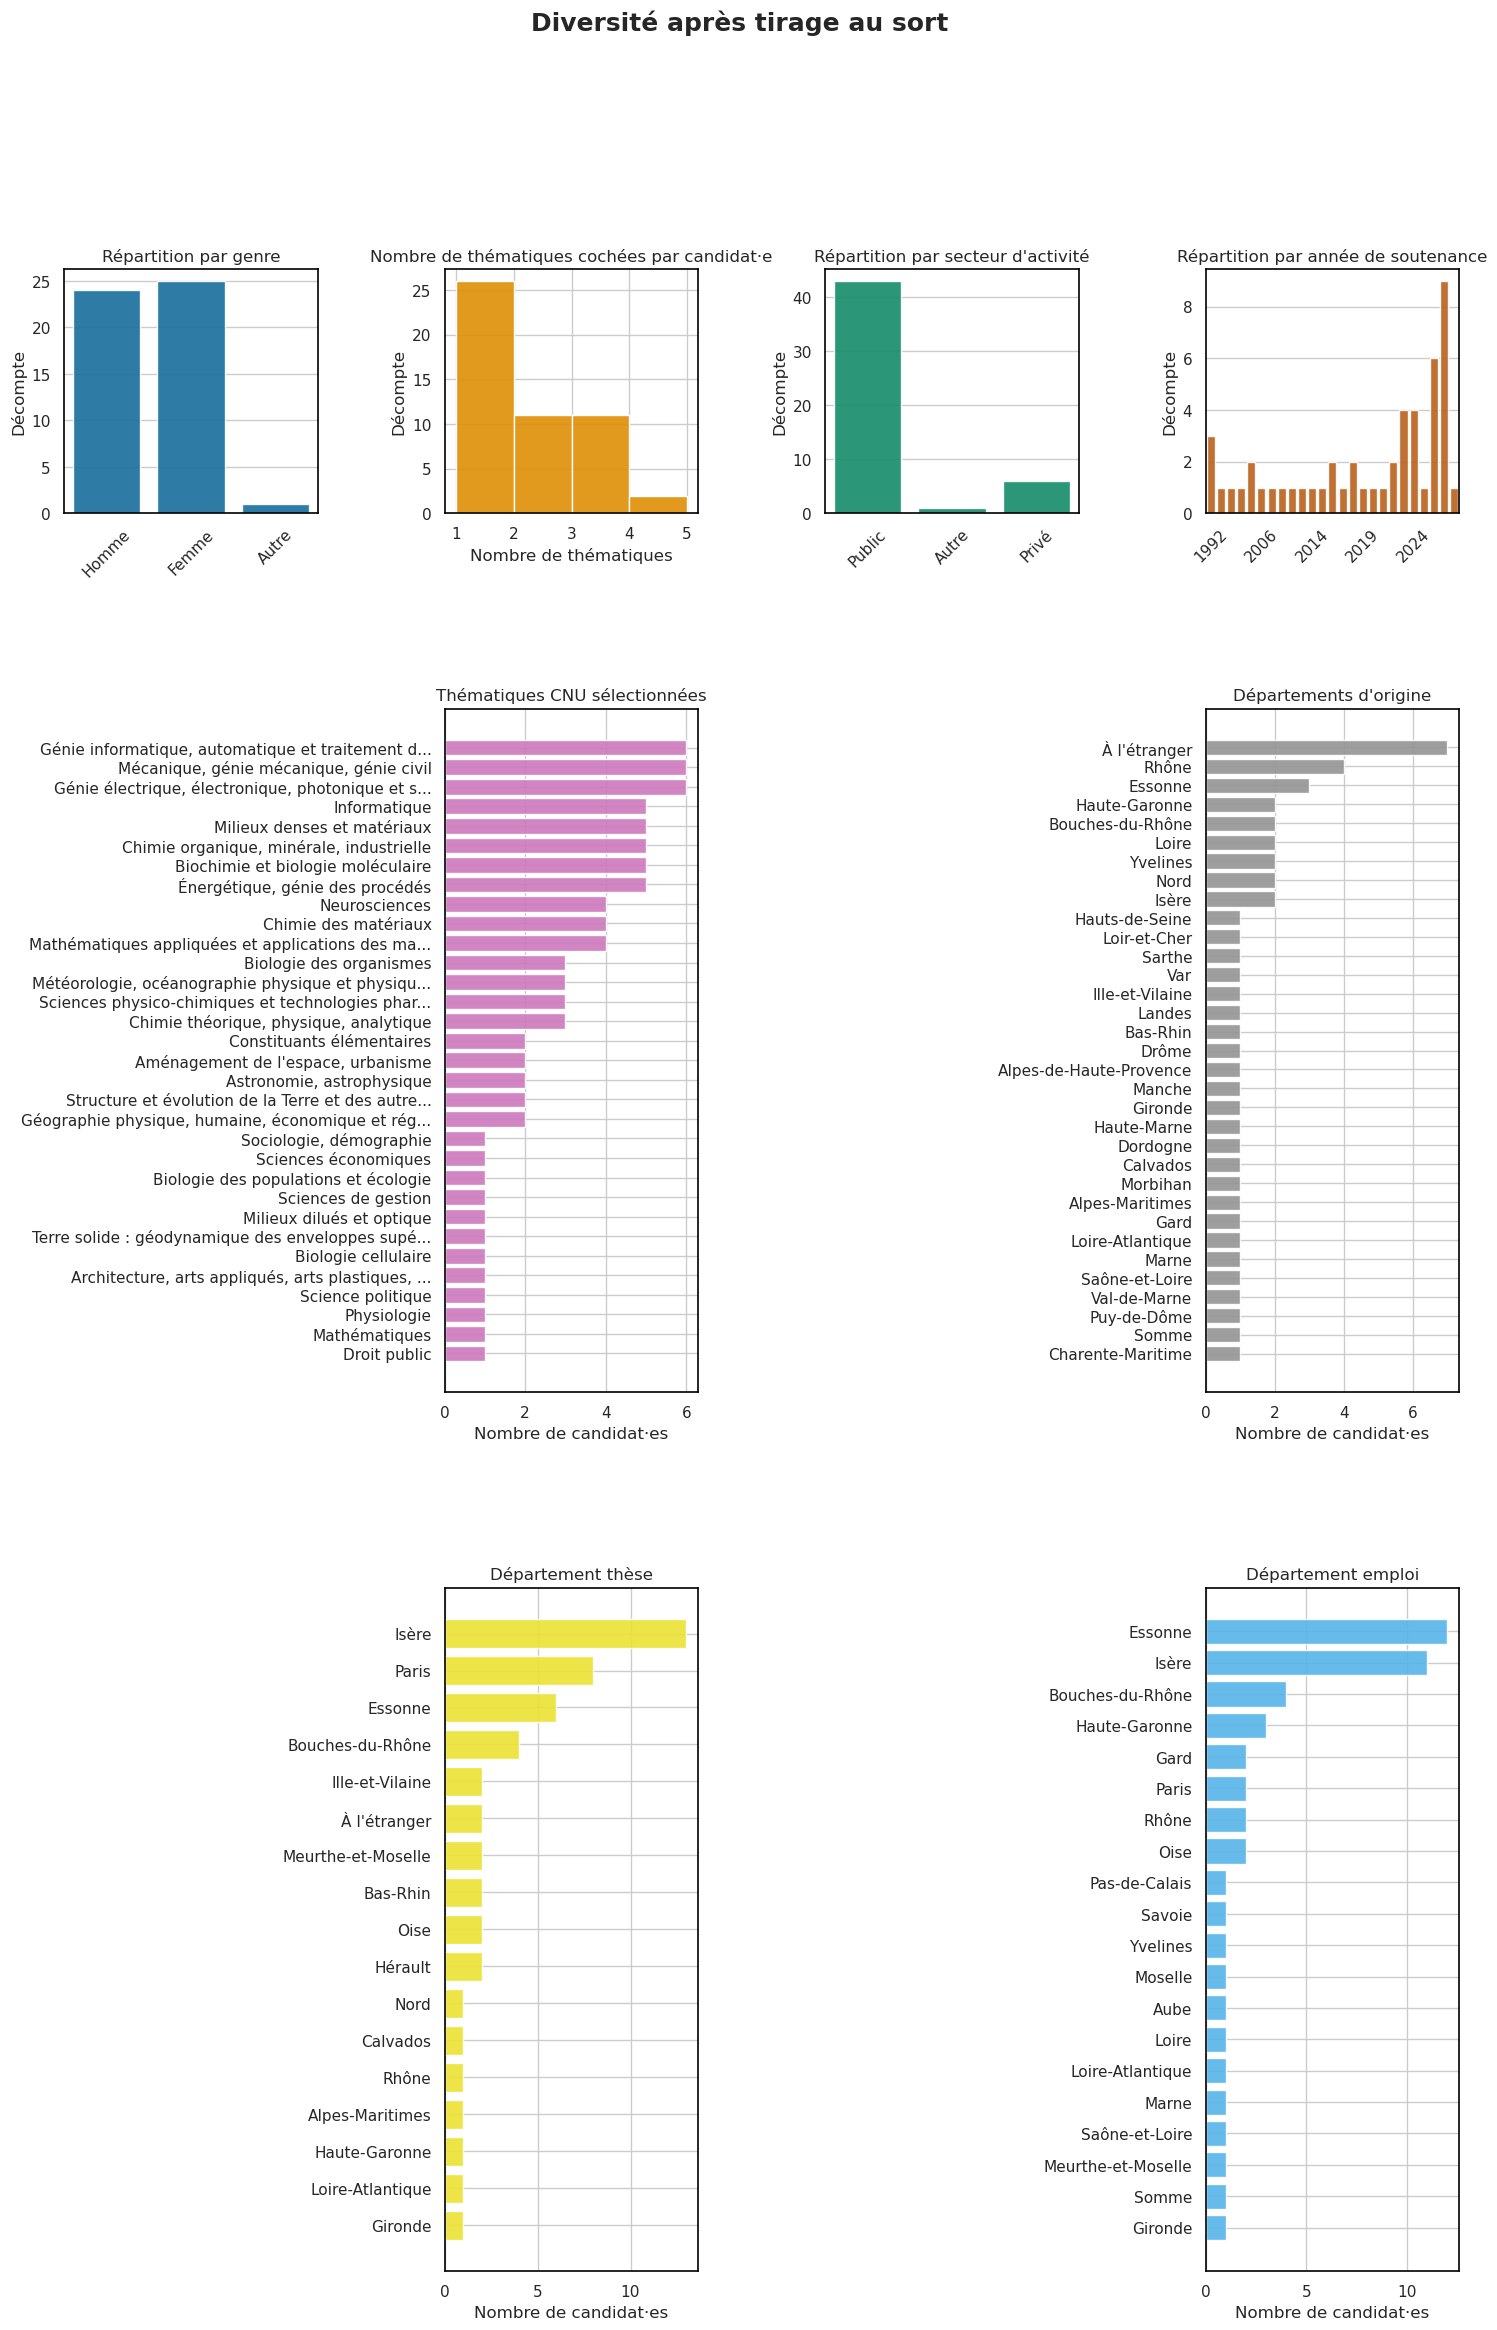

In [8]:
# Fonction pour couper les labels trop longs
def truncate_label(label, max_char=50):
    return label if len(label) <= max_char else label[:max_char - 3] + "..."

# Style et couleurs
palette = sns.color_palette("colorblind")
sns.set_theme(style="whitegrid")
alpha_bg = 0.9  # plus visible maintenant que le panel n'est plus présent
colors = palette[:10]
max_char = 50

# Préparation de la figure
fig = plt.figure(figsize=(18, 26), facecolor='white')
fig.suptitle("Diversité après tirage au sort", fontsize=18, weight='bold')

# Grille personnalisée
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 1], hspace=0.8, wspace=0.5)

# Petits graphiques (ligne 0)
ax1 = fig.add_subplot(gs[0, 0])  # Genre
ax2 = fig.add_subplot(gs[0, 1])  # Nb thématiques
ax3 = fig.add_subplot(gs[0, 2])  # Secteur
ax4 = fig.add_subplot(gs[0, 3])  # Année soutenance

# Grands graphiques (colonnes 1 et 3, lignes 1 à 4)
ax5 = fig.add_subplot(gs[1:3, 1])  # Thématiques
ax6 = fig.add_subplot(gs[1:3, 3])  # Département origine
ax7 = fig.add_subplot(gs[3:5, 1])  # Département thèse
ax8 = fig.add_subplot(gs[3:5, 3])  # Département emploi

# 1. Genre
sns.countplot(data=best_panel, x="Genre", ax=ax1, color=colors[0], alpha=alpha_bg)
ax1.set_title("Répartition par genre")
ax1.tick_params(axis='x', rotation=45)
ax1.set(xlabel=None, ylabel="Décompte")

# 2. Nombre de thématiques cochées
best_panel["Nb_thématiques"] = best_panel["Thématiques"].apply(len)
bins = range(1, best_panel["Nb_thématiques"].max() + 2)
sns.histplot(best_panel["Nb_thématiques"], bins=bins, ax=ax2, color=colors[1], alpha=alpha_bg)
ax2.set_title("Nombre de thématiques cochées par candidat·e")
ax2.set(xlabel="Nombre de thématiques", ylabel="Décompte")

# 3. Secteur
sns.countplot(data=best_panel, x="Secteur", ax=ax3, color=colors[2], alpha=alpha_bg)
ax3.set_title("Répartition par secteur d'activité")
ax3.tick_params(axis='x', rotation=45)
ax3.set(xlabel=None, ylabel="Décompte")

# 4. Année de soutenance
try:
    df_years = best_panel["Année soutenance"].dropna().astype(int).astype(str)
    all_years = sorted(df_years.unique())
    sns.countplot(x=df_years, order=all_years, ax=ax4, color=colors[3], alpha=alpha_bg)
    ax4.set_title("Répartition par année de soutenance")
    ax4.tick_params(axis='x', rotation=45)
    interval = 5
    tick_positions = np.arange(len(all_years))
    tick_labels = [year if i % interval == 0 else '' for i, year in enumerate(all_years)]
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    ax4.set(xlabel=None, ylabel="Décompte")
except Exception as e:
    ax4.axis("off")
    ax4.text(0.5, 0.5, f"Année de soutenance non exploitable\n({str(e)})", ha='center', va='center')

# 5. Thématiques
all_thematiques = list(set(t for sub in best_panel["Thématiques"] for t in sub))
df_counts = Counter([t for sub in best_panel["Thématiques"] for t in sub])
all_thematiques_sorted = sorted(all_thematiques, key=lambda x: df_counts.get(x, 0), reverse=True)
trunc_labels = [truncate_label(l, max_char) for l in all_thematiques_sorted]
df_vals = [df_counts.get(l, 0) for l in all_thematiques_sorted]
ax5.barh(trunc_labels, df_vals, color=colors[4], alpha=alpha_bg)
ax5.set_title("Thématiques CNU sélectionnées")
ax5.invert_yaxis()
ax5.set_xlabel("Nombre de candidat·es")
ax5.set(ylabel=None)

# 6. Département origine
all_depts = best_panel["Département origine"].dropna().unique()
df_vals_dept = best_panel["Département origine"].value_counts()
all_depts_sorted = df_vals_dept.index.tolist()
ax6.barh(all_depts_sorted, df_vals_dept.values, color=colors[7], alpha=alpha_bg)
ax6.set_title("Départements d'origine")
ax6.invert_yaxis()
ax6.set_xlabel("Nombre de candidat·es")
ax6.set(ylabel=None)

# 7. Département thèse
all_th = best_panel["Département thèse"].dropna().unique()
df_vals_th = best_panel["Département thèse"].value_counts()
all_th_sorted = df_vals_th.index.tolist()
ax7.barh(all_th_sorted, df_vals_th.values, color=colors[8], alpha=alpha_bg)
ax7.set_title("Département thèse")
ax7.invert_yaxis()
ax7.set_xlabel("Nombre de candidat·es")
ax7.set(ylabel=None)

# 8. Département emploi
all_emp = best_panel["Département emploi"].dropna().unique()
df_vals_emp = best_panel["Département emploi"].value_counts()
all_emp_sorted = df_vals_emp.index.tolist()
ax8.barh(all_emp_sorted, df_vals_emp.values, color=colors[9], alpha=alpha_bg)
ax8.set_title("Département emploi")
ax8.invert_yaxis()
ax8.set_xlabel("Nombre de candidat·es")
ax8.set(ylabel=None)

# Bordures noires
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

plt.show()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Comparaison avant et après tirage au sort</h2>
</div>

**Il peut être utile de visualiser sur un même graphique la répartition avant et après tirage au sort.**

**Ce bloc trace un ensemble de figures permettant de visualiser les différences entre population pré-sélectionnée et population tirée au sort :**
- Genre
- Nombre de thématiques cochées par candidat·es
- Secteur d'activité
- Année de soutenance
- Thémathique CNU
- Département :
    - d'origine
    - de thèse
    - d'emploi 

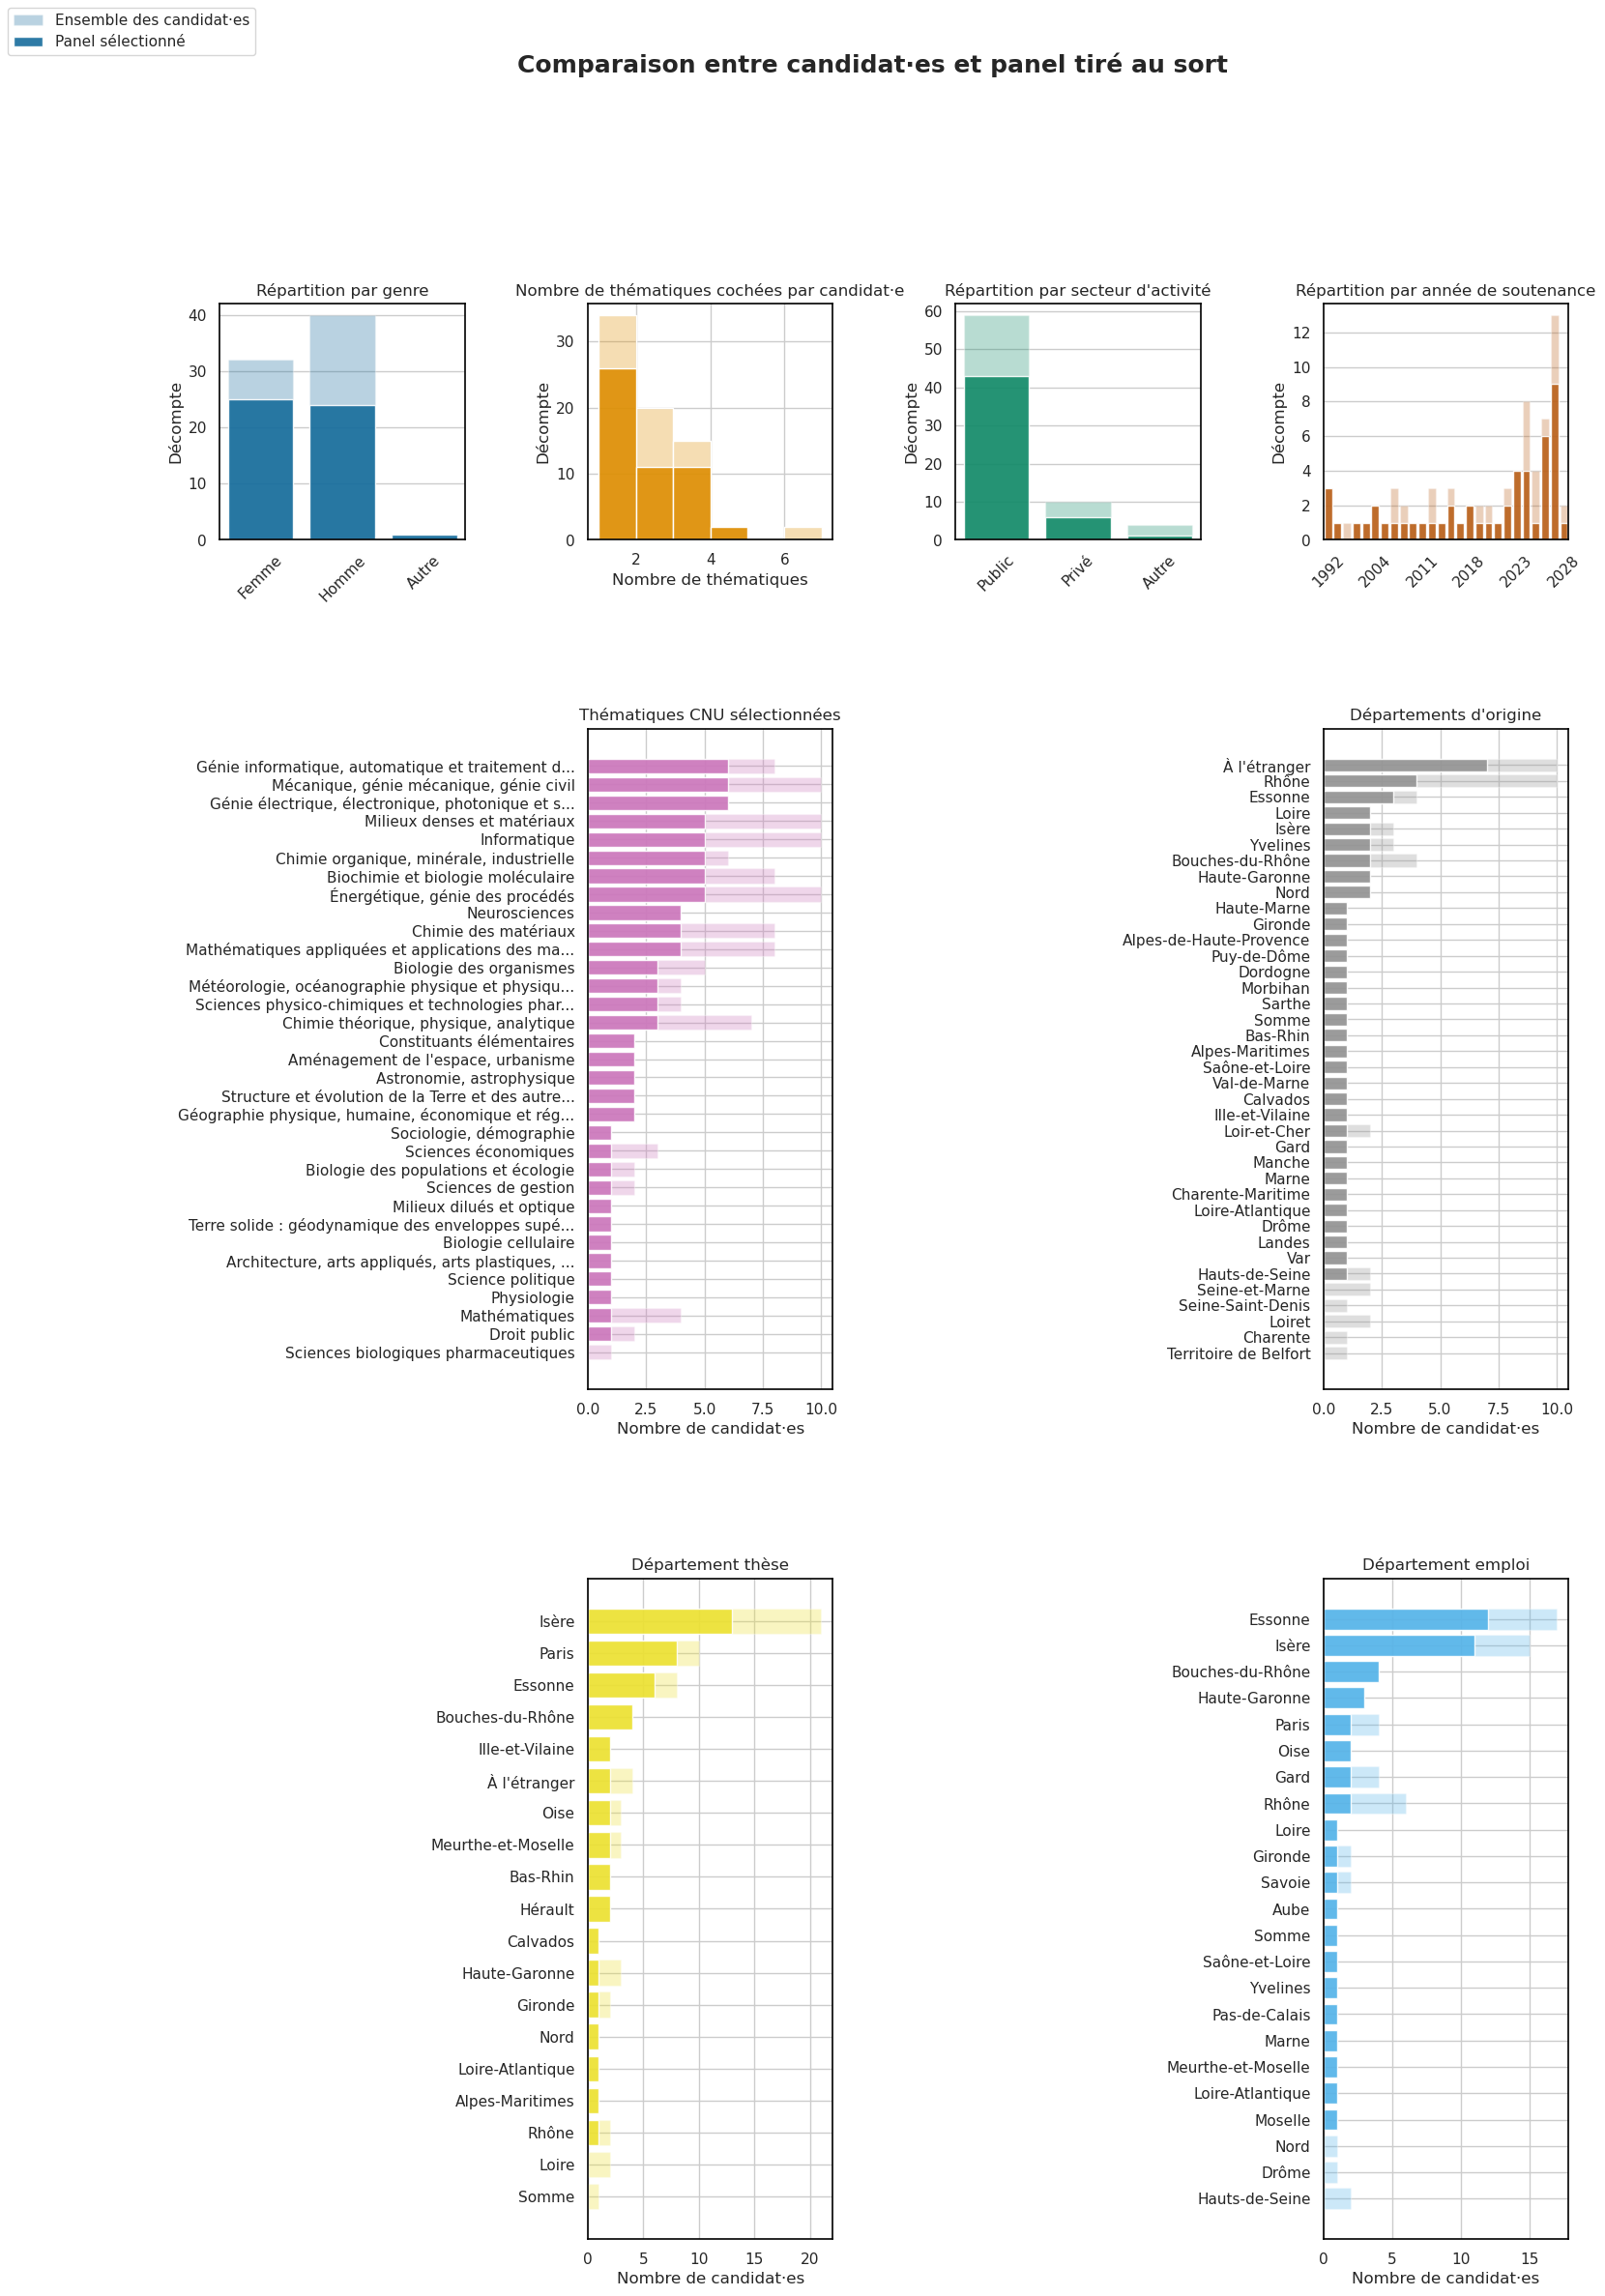

In [9]:
# Fonction pour couper les labels trop longs
def truncate_label(label, max_char=50):
    return label if len(label) <= max_char else label[:max_char - 3] + "..."

# Style et couleurs
palette = sns.color_palette("colorblind")
sns.set_theme(style="whitegrid")
alpha_bg = 0.3
alpha_fg = 0.9
colors = palette[:10]
max_char = 50

# Préparation de la figure
fig = plt.figure(figsize=(18, 26), facecolor='white')
fig.suptitle("Comparaison entre candidat·es et panel tiré au sort", fontsize=18, weight='bold')

# Grille personnalisée
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 1, 1], hspace=0.8, wspace=0.5)

# Petits graphiques (ligne 0)
ax1 = fig.add_subplot(gs[0, 0])  # Genre
ax2 = fig.add_subplot(gs[0, 1])  # Nb thématiques
ax3 = fig.add_subplot(gs[0, 2])  # Secteur
ax4 = fig.add_subplot(gs[0, 3])  # Année soutenance

# Grands graphiques (colonnes 1 et 3, lignes 1 à 4)
ax5 = fig.add_subplot(gs[1:3, 1])  # Thématiques
ax6 = fig.add_subplot(gs[1:3, 3])  # Département origine
ax7 = fig.add_subplot(gs[3:5, 1])  # Département thèse
ax8 = fig.add_subplot(gs[3:5, 3])  # Département emploi

labels_shared = ["Ensemble des candidat·es", "Panel sélectionné"]

# 1. Genre
sns.countplot(data=df_selection, x="Genre", ax=ax1, color=colors[0], alpha=alpha_bg)
sns.countplot(data=best_panel, x="Genre", ax=ax1, color=colors[0], alpha=alpha_fg)
ax1.set_title("Répartition par genre")
ax1.tick_params(axis='x', rotation=45)
ax1.set(xlabel=None)
ax1.set(ylabel="Décompte")

# 2. Nombre de thématiques cochées
df_selection["Nb_thématiques"] = df_selection["Thématiques"].apply(len)
best_panel["Nb_thématiques"] = best_panel["Thématiques"].apply(len)
bins = range(1, max(df_selection["Nb_thématiques"].max(), best_panel["Nb_thématiques"].max()) + 2)
sns.histplot(df_selection["Nb_thématiques"], bins=bins, ax=ax2, color=colors[1], alpha=alpha_bg)
sns.histplot(best_panel["Nb_thématiques"], bins=bins, ax=ax2, color=colors[1], alpha=alpha_fg)
ax2.set_title("Nombre de thématiques cochées par candidat·e")
ax2.set(xlabel="Nombre de thématiques")
ax2.set(ylabel="Décompte")

# 3. Secteur
sns.countplot(data=df_selection, x="Secteur", ax=ax3, color=colors[2], alpha=alpha_bg)
sns.countplot(data=best_panel, x="Secteur", ax=ax3, color=colors[2], alpha=alpha_fg)
ax3.set_title("Répartition par secteur d'activité")
ax3.tick_params(axis='x', rotation=45)
ax3.set(xlabel=None)
ax3.set(ylabel="Décompte")

# 4. Année de soutenance
try:
    df_years = df_selection["Année soutenance"].dropna().astype(int).astype(str)
    bp_years = best_panel["Année soutenance"].dropna().astype(int).astype(str)
    all_years = sorted(set(df_years.unique()) | set(bp_years.unique()))
    sns.countplot(x=df_years, order=all_years, ax=ax4, color=colors[3], alpha=alpha_bg)
    sns.countplot(x=bp_years, order=all_years, ax=ax4, color=colors[3], alpha=alpha_fg)
    ax4.set_title("Répartition par année de soutenance")
    ax4.tick_params(axis='x', rotation=45)
    interval = 5
    tick_positions = np.arange(len(all_years))
    tick_labels = [year if i % interval == 0 else '' for i, year in enumerate(all_years)]
    ax4.set_xticks(tick_positions)
    ax4.set_xticklabels(tick_labels, rotation=45)
    ax4.set(xlabel=None)
    ax4.set(ylabel="Décompte")
except Exception as e:
    ax4.axis("off")
    ax4.text(0.5, 0.5, f"Année de soutenance non exploitable\n({str(e)})", ha='center', va='center')

# 5. Toutes les thématiques (avec labels tronqués), triées par importance panel
all_thematiques = list(set(t for sub in df_selection["Thématiques"] for t in sub) | set(t for sub in best_panel["Thématiques"] for t in sub))
df_counts = Counter([t for sub in df_selection["Thématiques"] for t in sub])
panel_counts = Counter([t for sub in best_panel["Thématiques"] for t in sub])
all_thematiques_sorted = sorted(all_thematiques, key=lambda x: panel_counts.get(x, 0), reverse=True)
trunc_labels = [truncate_label(l, max_char) for l in all_thematiques_sorted]
df_vals = [df_counts.get(l, 0) for l in all_thematiques_sorted]
panel_vals = [panel_counts.get(l, 0) for l in all_thematiques_sorted]
ax5.barh(trunc_labels, df_vals, color=colors[4], alpha=alpha_bg)
ax5.barh(trunc_labels, panel_vals, color=colors[4], alpha=alpha_fg)
ax5.set_title("Thématiques CNU sélectionnées")
ax5.invert_yaxis()  # pour garder le label le plus important en haut
ax5.set_xlabel("Nombre de candidat·es")
ax5.set(ylabel=None)

# 6. Tous les départements d'origine, triés par importance panel
all_depts = list(set(df_selection["Département origine"].dropna()) | set(best_panel["Département origine"].dropna()))
panel_counts_depts = best_panel["Département origine"].value_counts()
all_depts_sorted = sorted(all_depts, key=lambda x: panel_counts_depts.get(x, 0), reverse=True)
df_vals_dept = df_selection["Département origine"].value_counts().reindex(all_depts_sorted).fillna(0)
panel_vals_dept = best_panel["Département origine"].value_counts().reindex(all_depts_sorted).fillna(0)
ax6.barh(all_depts_sorted, df_vals_dept.values, color=colors[7], alpha=alpha_bg)
ax6.barh(all_depts_sorted, panel_vals_dept.values, color=colors[7], alpha=alpha_fg)
ax6.set_title("Départements d'origine")
ax6.invert_yaxis()
ax6.set_xlabel("Nombre de candidat·es")
ax6.set(ylabel=None)

# 7. Département thèse, triés par importance panel
all_th = list(set(df_selection["Département thèse"].dropna()) | set(best_panel["Département thèse"].dropna()))
panel_counts_th = best_panel["Département thèse"].value_counts()
all_th_sorted = sorted(all_th, key=lambda x: panel_counts_th.get(x, 0), reverse=True)
df_vals_th = df_selection["Département thèse"].value_counts().reindex(all_th_sorted).fillna(0)
panel_vals_th = best_panel["Département thèse"].value_counts().reindex(all_th_sorted).fillna(0)
ax7.barh(all_th_sorted, df_vals_th.values, color=colors[8], alpha=alpha_bg)
ax7.barh(all_th_sorted, panel_vals_th.values, color=colors[8], alpha=alpha_fg)
ax7.set_title("Département thèse")
ax7.invert_yaxis()
ax7.set_xlabel("Nombre de candidat·es")
ax7.set(ylabel=None)

# 8. Département emploi, triés par importance panel
all_emp = list(set(df_selection["Département emploi"].dropna()) | set(best_panel["Département emploi"].dropna()))
panel_counts_emp = best_panel["Département emploi"].value_counts()
all_emp_sorted = sorted(all_emp, key=lambda x: panel_counts_emp.get(x, 0), reverse=True)
df_vals_emp = df_selection["Département emploi"].value_counts().reindex(all_emp_sorted).fillna(0)
panel_vals_emp = best_panel["Département emploi"].value_counts().reindex(all_emp_sorted).fillna(0)
ax8.barh(all_emp_sorted, df_vals_emp.values, color=colors[9], alpha=alpha_bg)
ax8.barh(all_emp_sorted, panel_vals_emp.values, color=colors[9], alpha=alpha_fg)
ax8.set_title("Département emploi")
ax8.invert_yaxis()
ax8.set_xlabel("Nombre de candidat·es")
ax8.set(ylabel=None)

# Bordures noires
for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.2)

# Légende partagée
fig.legend(labels_shared, loc='upper left', fontsize=11, frameon=True, fancybox=True)

plt.show()

<div style="border: 2px solid #FFA500; padding: 10px; border-radius: 5px; background-color: #FFFACD; color: black; text-align: center;">
  <h2 style="margin: 0;">Exportation</h2>
</div>

**Ce bloc sauvegarde la solution retenue dans un fichier CSV nommé *panel_choisi.csv***

In [ ]:
df_draw = pd.DataFrame(best_panel)
df_draw.to_csv("../data/panel_choisi.csv", index=False, header=True)